In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [226]:
df =pd.read_csv('sp500_closefull.csv',index_col=0,parse_dates=True)

In [227]:
df

,CSCO,UAL,TROW,ISRG,PRGO,TPR,DVN,MRO,BA,VRTX,...,M,CRM,PGR,WAT,BWA,LRCX,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,24.690001,12.800000,54.400002,102.923332,40.349998,36.310001,76.570000,19.153616,56.180000,44.240002,...,17.059999,18.705000,18.030001,61.630001,16.889999,39.880001,15.200000,3.51000,238.580002,30.242558
2010-01-05,24.580000,13.910000,55.009998,102.459999,38.790001,36.750000,76.650002,19.171511,58.020000,42.779999,...,16.860001,18.625000,17.969999,60.790001,17.695000,39.610001,15.110000,3.61500,239.610001,29.851370
2010-01-06,24.420000,13.270000,54.150002,103.946663,38.299999,37.470001,76.419998,19.595024,59.779999,42.029999,...,17.100000,18.592501,17.790001,60.900002,18.344999,39.430000,15.380000,3.69500,234.669998,29.916569
2010-01-07,24.530001,13.550000,54.110001,103.556664,37.990002,37.490002,75.970001,19.475725,62.200001,41.500000,...,17.490000,18.510000,17.549999,61.160000,18.594999,39.360001,15.820000,3.65125,237.250000,29.627834
2010-01-08,24.660000,13.330000,53.900002,102.986664,37.779999,37.270000,76.120003,19.505550,61.599998,40.669998,...,16.920000,18.537500,17.709999,61.209999,18.254999,40.349998,15.770000,3.64375,238.919998,29.534695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,40.279999,79.120003,84.949997,434.890015,36.500000,32.299999,20.980000,12.660000,294.160004,151.910004,...,28.150000,121.330002,57.070000,173.539993,33.200001,123.279999,17.950001,16.75000,361.769989,27.590000
2018-12-26,42.470001,83.800003,89.650002,461.980011,40.700001,33.889999,22.709999,14.170000,313.929993,161.839996,...,30.129999,130.839996,59.330002,181.190002,34.400002,130.839996,18.910000,17.82000,381.230011,28.309999
2018-12-27,42.910000,83.040001,91.309998,468.700012,39.619999,34.150002,22.900000,14.290000,317.140015,162.369995,...,30.040001,135.199997,60.200001,185.179993,34.770000,133.279999,18.400000,17.91000,387.799988,28.340000


In [228]:
import time
import numpy as np
from requests.sessions import InvalidSchema
import yfinance as yf
import time
import datetime
import psycopg2
import psycopg2.extras
from sqlalchemy import create_engine

In [229]:
class Config:
    DB_HOST ='localhost'
    DB_USER ='postgres'
    DB_PASS ='password'
    DB_NAME ='prices'
    API_URL = "https://paper-api.alpaca.markets"
    API_KEY  = "PKTE1915P0HLD2R6B8E6"
    API_SECRET ="OtIa186qJPsGCPzYTryYJI74dkMq5xEEhs0bJNZP"
    DB_PORT ="5432"
config = Config()

In [247]:
query ="""select * from assets ORDER BY date ASC;"""
connection=psycopg2.connect(host=config.DB_HOST, database=config.DB_NAME, user= config.DB_USER, password=config.DB_PASS)
cursor = connection.cursor(cursor_factory=psycopg2.extras.DictCursor)
engine = create_engine(f'postgresql://{config.DB_USER}:{config.DB_PASS}@{config.DB_HOST}:{config.DB_PORT}/{config.DB_NAME}')

df = pd.read_sql_query(query,con=engine)

def drop_na_bf_fill(df):
    """drop_na_bf_fill"""
    df.dropna(axis=0,how='all',inplace=True)
    df.dropna(axis=1,how='any',inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def get_close_values_of_df(df):
    """get_close_values_of_df"""
    symbols = df['name'].unique()
    df_msft = df[df['name'] == 'MSFT']
    final_df = pd.DataFrame(data=df_msft['close'].to_numpy(), index = df_msft['date'],columns=['MSFT'])
    for symbol in symbols:
        if symbol != 'MSFT':
            df_sym = df[df['name'] == symbol]
            df_tmp = pd.DataFrame(data=df_sym['close'].to_numpy(), index = df_sym['date'],columns=[symbol])
            final_df =final_df.join(df_tmp)
    return drop_na_bf_fill(final_df)

def get_returns(df):
    """get_returns"""
    df = get_close_values_of_df(df)
    for symbol in df.columns.values:
        df[f'{symbol}_Prev_close']=df[symbol].shift(1)
        df[f'{symbol}_Return'] = df[f'{symbol}'] / df[f'{symbol}_Prev_close'] - 1
        df[f'{symbol}_Log_Return'] = np.log(df[f'{symbol}_Return'] + 1)
    return df

df = get_returns(df)
log_return_list= ['MSFT_Log_Return','AAPL_Log_Return','NVDA_Log_Return','UBER_Log_Return','COIN_Log_Return']
df=df[log_return_list]

roc_auc_score: 1.0
[0. 0. 0. 1.]
[0.         0.00980392 1.         1.        ]
[1.54002683 0.54002683 0.50002465 0.44128762]


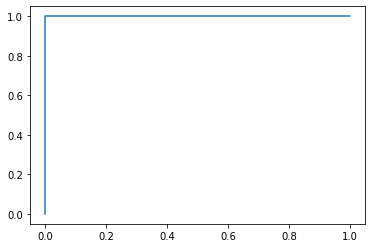

0.35138155369064955
0


In [248]:
df['MSFT_Log_Return']=df['MSFT_Log_Return'].shift(-1)
df['MSFT_Log_Return'].tail()

Ntest=1000
train =df.iloc[1:-Ntest]
test =df.iloc[-Ntest:-1]

Xtrain =train[log_return_list]
Ytrain =train['MSFT_Log_Return']
Xtest = test[log_return_list]
Ytest = test['MSFT_Log_Return']

# from sklearn.linear_model import LinearRegression
# model =LinearRegression()
# model.fit(Xtrain, Ytrain)
# model.score(Xtrain, Ytrain), model.score(Xtest,Ytest)

# #Direction
# Ptrain =model.predict(Xtrain)
# Ptest =model.predict(Xtest)
# np.mean( np.sign(Ptrain) == np.sign(Ytrain)), np.mean(np.sign(Ptest) == np.sign(Ytest))


from sklearn.linear_model import LogisticRegression
#reg penality, prevent the weight fro becoming too large
model =LogisticRegression(C=10)
Ctrain = (Ytrain>0)
Ctest = (Ytest>0)
model.fit(Xtrain, Ctrain)
model.score(Xtrain, Ctrain) , model.score(Xtest, Ctest)

Ptrain =model.predict(Xtrain)
Ptest =model.predict(Xtest)
set(Ptrain), set(Ptest)

y_test_pp = model.predict_proba(Xtest)
print('roc_auc_score:', roc_auc_score(Ptest, y_test_pp[:,1]))
fpr, tpr, thres = roc_curve(Ptest, y_test_pp[:,1])
print(fpr)
print(tpr)
print(thres)
ax = plt.plot(fpr, tpr)
plt.show()

df.loc[1:-Ntest,'Position'] = Ptrain
df.loc[-Ntest:-1,'Position'] = Ptest 
df['AlgoReturn'] = df['Position'] *  df['MSFT_Log_Return']
#Total algo log return test
print(df.iloc[-Ntest:-1]['AlgoReturn'].sum())
#Total algo log return test
print(df.iloc[-1:-Ntest]['AlgoReturn'].sum())
#Total return buy-and-hold train
# Ytrain.sum(), Ytest.sum()


In [130]:
df.dropna(axis=0,how='all',inplace=True)

In [131]:
df.shape

(2263, 480)

In [132]:
df.dropna(axis=1,how='any',inplace=True)

In [133]:
df.shape

(2263, 429)

In [134]:
df.isna().sum().sum()

0

In [135]:
df_returns = pd.DataFrame()

In [136]:
for name in df.columns:
    df_returns[name] = np.log(df[name]).diff()

/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/3684760641.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df[name]).diff()
/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/3684760641.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df[name]).diff()
/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/3684760641.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [137]:
df_returns.head()

,CSCO,UAL,TROW,ISRG,PRGO,TPR,DVN,MRO,BA,VRTX,...,M,CRM,PGR,WAT,BWA,LRCX,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.004465,0.083163,0.011151,-0.004512,-0.039429,0.012045,0.001044,0.000934,0.032227,-0.033559,...,-0.011793,-0.004286,-0.003333,-0.013723,0.046560,-0.006793,-0.005939,0.029476,0.004308,-0.013019
2010-01-06,-0.006531,-0.047102,-0.015757,0.014405,-0.012713,0.019402,-0.003005,0.021850,0.029883,-0.017687,...,0.014134,-0.001746,-0.010067,0.001808,0.036075,-0.004555,0.017711,0.021889,-0.020832,0.002182
2010-01-07,0.004494,0.020881,-0.000739,-0.003759,-0.008127,0.000534,-0.005906,-0.006107,0.039684,-0.012690,...,0.022551,-0.004447,-0.013583,0.004260,0.013536,-0.001777,0.028207,-0.011911,0.010934,-0.009698
2010-01-08,0.005286,-0.016369,-0.003889,-0.005519,-0.005543,-0.005886,0.001973,0.001530,-0.009693,-0.020203,...,-0.033133,0.001485,0.009075,0.000817,-0.018454,0.024841,-0.003166,-0.002056,0.007014,-0.003149


In [206]:
df.head()

,MSFT_Log_Return,AAPL_Log_Return,BTC-USD_Log_Return,ETH-USD_Log_Return,GOOG_Log_Return
date,,,,,
2022-03-22 13:30:00,NaN,NaN,NaN,NaN,NaN
2022-03-22 13:35:00,0.000325,0.003697,0.000414,0.000956,0.010706
2022-03-22 13:40:00,0.001097,0.000265,0.001641,0.000378,-0.001853
2022-03-22 13:45:00,-0.003561,-0.002578,-0.002763,-0.002981,-0.002183
2022-03-22 13:50:00,-0.001903,-0.001444,-0.001386,-0.001958,-0.000072


In [237]:
df['GOOG_Log_Return']=df['GOOG_Log_Return'].shift(-1)
df['GOOG_Log_Return'].tail()

Ntest=1000
train =df.iloc[1:-Ntest]
test =df.iloc[-Ntest:-1]

Xtrain =train[log_return_list]
Ytrain =train['GOOG_Log_Return']
Xtest = test[log_return_list]
Ytest = test['GOOG_Log_Return']

from sklearn.linear_model import LinearRegression
model =LinearRegression()
model.fit(Xtrain, Ytrain)
model.score(Xtrain, Ytrain), model.score(Xtest,Ytest)

#Direction
Ptrain =model.predict(Xtrain)
Ptest =model.predict(Xtest)
np.mean( np.sign(Ptrain) == np.sign(Ytrain)), np.mean(np.sign(Ptest) == np.sign(Ytest))

from sklearn.linear_model import LogisticRegression
#reg penality, prevent the weight fro becoming too large
model =LogisticRegression(C=10)
Ctrain = (Ytrain>0)
Ctest = (Ytest>0)
model.fit(Xtrain, Ctrain)
model.score(Xtrain, Ctrain) , model.score(Xtest, Ctest)

Ptrain =model.predict(Xtrain)
Ptest =model.predict(Xtest)
set(Ptrain), set(Ptest)

y_test_pp = model.predict_proba(Xtest)
print('roc_auc_score:', roc_auc_score(Ptest, y_test_pp[:,1]))
fpr, tpr, thres = roc_curve(Ptest, y_test_pp[:,1])
print(fpr)
print(tpr)
print(thres)
ax = plt.plot(fpr, tpr)
plt.show()



KeyError: 'GOOG_Log_Return'

In [138]:
df_returns['SPY']=df_returns['SPY'].shift(-1)
df_returns['SPY'].tail()

Date
2018-12-21   -0.026778
2018-12-24    0.049290
2018-12-26    0.007648
2018-12-27   -0.001291
2018-12-28         NaN
Name: SPY, dtype: float64

In [139]:
Ntest=1000
train =df_returns.iloc[1:-Ntest]
test =df_returns.iloc[-Ntest:-1]

In [140]:
[range(1,-Ntest)]

[range(1, -1000)]

In [141]:
df_returns.columns

Index(['CSCO', 'UAL', 'TROW', 'ISRG', 'PRGO', 'TPR', 'DVN', 'MRO', 'BA',
       'VRTX',
       ...
       'M', 'CRM', 'PGR', 'WAT', 'BWA', 'LRCX', 'NWL', 'UAA', 'BLK', 'PPL'],
      dtype='object', length=429)

In [142]:
x_cols = ['AAPL','MSFT','AMZN','JNJ','V','PG','JPM']
x_cols

['AAPL', 'MSFT', 'AMZN', 'JNJ', 'V', 'PG', 'JPM']

In [143]:
Xtrain =train[x_cols]
Ytrain =train['SPY']
Xtest = test[x_cols]
Ytest = test['SPY']

In [144]:
Xtrain.head()

,AAPL,MSFT,AMZN,JNJ,V,PG,JPM
Date,,,,,,,
2010-01-05,0.001727,0.000323,0.005883,-0.011663,-0.011525,0.000327,0.019185
2010-01-06,-0.016034,-0.006156,-0.018282,0.008101,-0.013519,-0.004755,0.005479
2010-01-07,-0.001850,-0.010454,-0.017160,-0.007163,0.009264,-0.005438,0.019615
2010-01-08,0.006626,0.006873,0.026717,0.003432,0.002762,-0.001323,-0.002459
2010-01-11,-0.008861,-0.012802,-0.024335,0.000156,-0.002878,-0.003979,-0.003363


In [145]:
Ytrain.head()

Date
2010-01-05    0.000704
2010-01-06    0.004212
2010-01-07    0.003322
2010-01-08    0.001396
2010-01-11   -0.009370
Name: SPY, dtype: float64

In [146]:
from sklearn.linear_model import LinearRegression
model =LinearRegression()
model.fit(Xtrain, Ytrain)
model.score(Xtrain, Ytrain), model.score(Xtest,Ytest)

(0.008271754178782564, -0.011369618185063324)

In [147]:
#Direction
Ptrain =model.predict(Xtrain)
Ptest =model.predict(Xtest)
np.mean( np.sign(Ptrain) == np.sign(Ytrain)), np.mean(np.sign(Ptest) == np.sign(Ytest))

(0.528526148969889, 0.5285285285285285)

In [148]:
# y_test_pp = model.predict_proba(Xtest)
# print('roc_auc_score:', roc_auc_score(Ptest, y_test_pp[:,1]))
# fpr, tpr, thres = roc_curve(Ptest, y_test_pp[:,1])
# ax = plt.plot(fpr, tpr)
# plt.show()

In [149]:
set(np.sign(Ptrain)), set(np.sign(Ptest))

({-1.0, 1.0}, {-1.0, 1.0})

In [150]:
df_returns['Position'] =0
df_returns.loc[1:-Ntest,'Position'] = (Ptrain > 0)
df_returns.loc[-Ntest:-1,'Position'] = (Ptest > 0)

/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/312600863.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns['Position'] =0
/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/312600863.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_returns.loc[1:-Ntest,'Position'] = (Ptrain > 0)
/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/312600863.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_returns.loc[-Ntest:-1,'Position'] = (Ptest > 0)


In [151]:
df_returns['AlgoReturn'] = df_returns['Position'] *  df_returns['SPY']

/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/3654636993.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns['AlgoReturn'] = df_returns['Position'] *  df_returns['SPY']


In [152]:
#Total algo log return train
df_returns.iloc[1:-Ntest]['AlgoReturn'].sum()

0.5477174926058392

In [153]:
#Total algo log return test
df_returns.iloc[-Ntest:-1]['AlgoReturn'].sum()

0.3037759916491991

In [154]:
#Total return buy-and-hold train
Ytrain.sum()

0.5863972019814705

In [155]:
#Total return buy-and-hold test
Ytest.sum()

0.19307543946998518

In [156]:
from sklearn.linear_model import LogisticRegression
#reg penality, prevent the weight fro becoming too large
model =LogisticRegression(C=10)
Ctrain = (Ytrain>0)
Ctest = (Ytest>0)
model.fit(Xtrain, Ctrain)
model.score(Xtrain, Ctrain) , model.score(Xtest, Ctest)

(0.5586370839936609, 0.5285285285285285)

In [157]:
Ptrain =model.predict(Xtrain)
Ptest =model.predict(Xtest)
set(Ptrain), set(Ptest)

({False, True}, {False, True})

roc_auc_score: 1.0
[0. 0. 0. 1.]
[0.       0.001002 1.       1.      ]
[1.60948021 0.60948021 0.50148104 0.49705477]


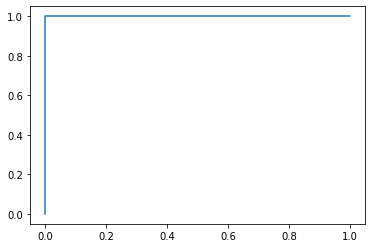

In [158]:
y_test_pp = model.predict_proba(Xtest)
print('roc_auc_score:', roc_auc_score(Ptest, y_test_pp[:,1]))
fpr, tpr, thres = roc_curve(Ptest, y_test_pp[:,1])
print(fpr)
print(tpr)
print(thres)
ax = plt.plot(fpr, tpr)
plt.show()

In [159]:
df_returns.loc[1:-Ntest,'Position'] = Ptrain
df_returns.loc[-Ntest:-1,'Position'] = Ptest 
df_returns['AlgoReturn'] = df_returns['Position'] *  df_returns['SPY']

/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/3617963604.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_returns.loc[1:-Ntest,'Position'] = Ptrain
/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/3617963604.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_returns.loc[-Ntest:-1,'Position'] = Ptest


In [160]:
#Total algo log return test
df_returns.iloc[-Ntest:-1]['AlgoReturn'].sum()

0.19680747922142316

In [161]:
#Total algo log return test
df_returns.iloc[-1:-Ntest]['AlgoReturn'].sum()

0

In [162]:
#Total return buy-and-hold train
Ytrain.sum(), Ytest.sum()

(0.5863972019814705, 0.19307543946998518)

In [163]:
#Total return buy-and-hold test
Ytest.sum()

0.19307543946998518

In [164]:
# combines expressiveness of decision trees alon with the variance reduction. random state can be chanfed
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)
model.fit(Xtrain,Ctrain)
model.score(Xtrain,Ctrain), model.score(Xtest,Ctest) 


(1.0, 0.5195195195195195)

In [165]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

roc_auc_score: 1.0


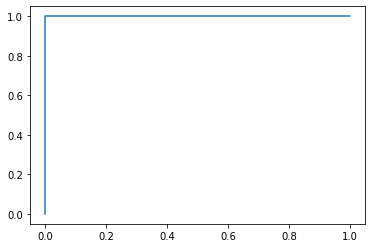

In [166]:
y_test_pp = model.predict_proba(Xtest)
print('roc_auc_score:', roc_auc_score(Ptest, y_test_pp[:,1]))
fpr, tpr, thres = roc_curve(Ptest, y_test_pp[:,1])
ax = plt.plot(fpr, tpr)
plt.show()

In [167]:
df_returns.loc[1:-Ntest,'Position'] = Ptrain
df_returns.loc[-Ntest:-1,'Position'] = Ptest

/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/343600564.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_returns.loc[1:-Ntest,'Position'] = Ptrain
/var/folders/6z/zfrlwktn1ls42xz760mlmp880000gn/T/ipykernel_38121/343600564.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_returns.loc[-Ntest:-1,'Position'] = Ptest


In [168]:
df_returns['AlgoReturn'] = df_returns['Position'] *  df_returns['SPY']

In [169]:
#Total algo log return train
df_returns.iloc[1:-Ntest]['AlgoReturn'].sum()

4.706503557502187

In [170]:
#Total algo log return test
df_returns.iloc[-Ntest:-1]['AlgoReturn'].sum()

0.3273909023793813

In [171]:
Ytrain.sum(), Ytest.sum()

(0.5863972019814705, 0.19307543946998518)

In [172]:
# !data matters
# multiple lags --> vector auto regressive model 
# do not assume cnn/rnn are work tba liner
# european asian market
# twitter news
#